
There might be lots of differend models for grading. Firstly, for example, putting the individual scores together:
* based on the best score
* based on the total score ($\frac{1}{3}$ weight for each part)
* based on a linear model
> as the assignment states, this will be my concern, so the linear part of the model will have 4 parameters, 3 for the input scores and a bias factor
* even subjectively, etc.

Then, they are perhaps combined with a grading function which takes this combined score and translates it to a grade, this function is very likely discontinuous, based on specific thresholds.


In [2]:
#!/usr/bin/python3

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=[14.0, 5.0] # bigger graphs
import keras

with np.load("grading.npz") as data:
    x = data['x']
    y = data['y']

# the shapes are a bit different then expected,
# just making sure following holds
assert (4000, 3) == x.shape
assert (4000,  ) == y.shape
assert isinstance(x[0,0], np.float64)
assert isinstance(y[0],   np.float64)

_Note: looks like it does not matter whether the output tensor is of shape (n, 1) or just a simple vector (n, ), the latter is a bit more convenient to manipulate, so I will leave it that way..._

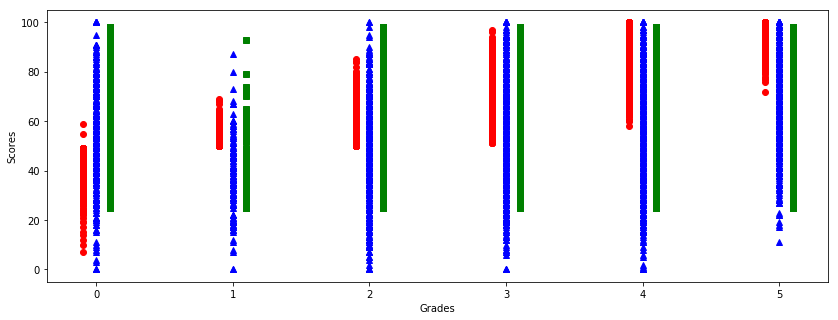

In [3]:
# short 'at-a-glance' analysis of the data
plt.plot(y-0.1, x[:,0], "ro")
plt.plot(y,     x[:,1], "b^")
plt.plot(y+0.1, x[:,2], "gs")
plt.xlabel('Grades')
plt.ylabel('Scores')
plt.show()

In the graph above it seems that there is highest correlation between grades and the first scores (red dots) - its respective weight in the model will be likely highest, then there is a big overall variance.

It also looks like the scores are just mere percentages (ranging from 0 to 100), let's see.

In [4]:
print("      min    max")
for i in range(3):
    print("{}: {: 6.1f} {: 6.1f}"
          .format(i,
                  np.min(x[:,i]),
                  np.max(x[:,i]) ))

      min    max
0:    7.0  100.0
1:    0.0  100.0
2:   25.0   98.0


That looks affirmative, therefore I would like training the model using two different normalizations and comparing them - i.e.:
1. normalizing by dividing by 100 _(could be applied to the data immediately, it would change mean and std linearly)_

2. normalizing using mean and standard deviation (measured on the training data)

<br/>
_About time to split the data to training and testing datasets..._

mean: [73.833 55.249 62.047]
 std: [17.97114662 19.69824863 21.61653976]


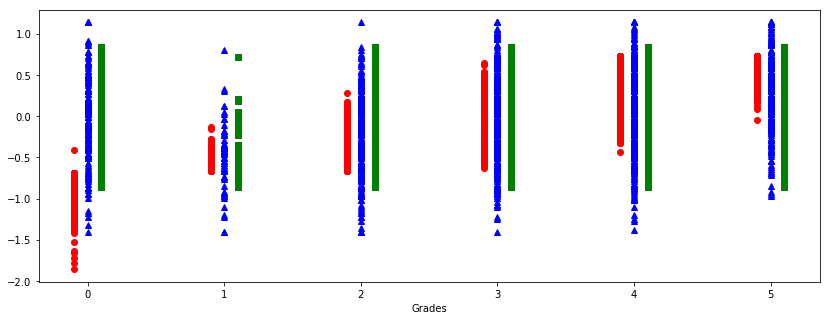

In [5]:
TS = 2000 # number of Training Samples

x_train, x_test = x[:TS], x[TS:]
y_train, y_test = y[:TS], y[TS:]

mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
print("mean: {}\n std: {}".format(mean, std))

# First normalization
x_train1 = x_train / 100.0
x_test1  = x_test / 100.0

# Second normalization
x_train2 = (x_train - mean) / (2 * std)
x_test2 = (x_test - mean) / (2 * std)

plt.plot(y_train-0.1, x_train2[:,0], "ro")
plt.plot(y_train,     x_train2[:,1], "b^")
plt.plot(y_train+0.1, x_train2[:,2], "gs")
plt.xlabel('Grades')
plt.show()

### Let's have a look how will this trivial model perform and at some benchmarks

In the first steps I will have a look at the relation among number of epochs, batch sizes, computational time and loss function on this model. Only at the end I will assess how well it is doing.

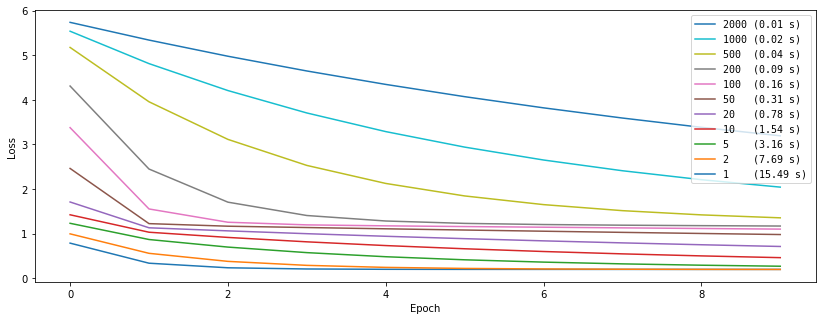

In [6]:
import keras
import time

model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_shape=(3,)))
model.compile(optimizer='sgd', loss='mse')

weights = model.get_weights()

batch_sizesA = (1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000)

histA = list()

for bs in batch_sizesA:
    # reset weights so that it begins from the same position every time
    model.set_weights(weights)
    
    # measure how long it takes
    start_time = time.process_time()
    history = model.fit(x_train1, y_train,
                        batch_size=bs, epochs=10, shuffle=False, verbose=0)
    elapsed_time = time.process_time() - start_time
    
    # append (history, elapsed_time, weights)
    histA.append( (history, elapsed_time, model.get_weights()) )

# draw how fast were individual batch sizes converging
legendA = list()
for i in range(len(histA)):
    line, = plt.plot(histA[i][0].history['loss'])
    legendA.append(line)
    
plt.rcParams["font.family"] = "monospace"
plt.legend(legendA[::-1], list(
    map("{:<4} ({:.2f} s)".format, batch_sizesA, np.array(histA)[:,1]))[::-1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

The graph nicely shows the speed of convergence of the loss function near its minimum relative to number of epochs, the legend contains the batch size for a given line and time it took to run 10 epochs. The smaller the batch size the fewer epochs to converge but the longer time one epoch takes.

In [10]:
losses = list()
for h in histA:
    losses.extend(h[0].history['loss'])
    
losses.sort()
print(losses[:10])


[0.19505425715137972, 0.19603166170104272, 0.19603387450423976, 0.19605628145859988, 0.19616711678699347, 0.19663298565456921, 0.1966895467310751, 0.19847181542884507, 0.19987220254181193, 0.20553142036655575]


To see which combination number of epochs and batch sizes works the best timewise, let's now try counting how many epochs and how much time is needed for a given batch size so that the loss is less then, say 0.2.

/usr/lib/python3.6/site-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


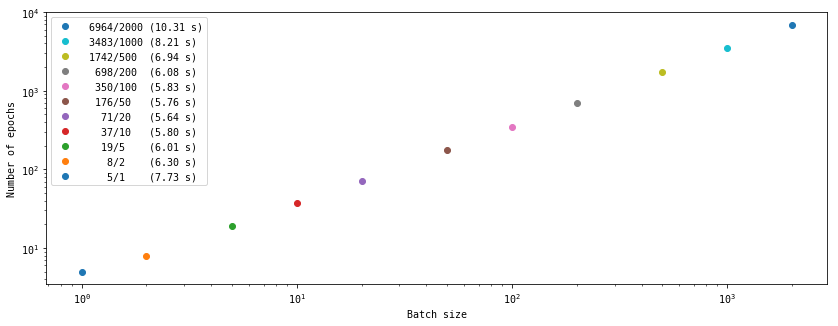

In [11]:
THRESHOLD = 0.2

histB = list()

for bs in batch_sizesA:
    # reset weights so that it begins from the same position every time
    model.set_weights(weights)
    
    history = list()
    t = 1000.0
    # measure how long it takes
    start_time = time.process_time()
    while (t > THRESHOLD): # one epoch a time
        h = model.fit(x_train1, y_train,
                            batch_size=bs, epochs=1, shuffle=False, verbose=0)
        t = h.history['loss'][0]
        history.append(t)
    elapsed_time = time.process_time() - start_time
    
    # append (history, elapsed_time, weights)
    histB.append( (history, elapsed_time, model.get_weights()) )
    
# drawing
legendB = list()
for i in range(len(histB)):
    line, = plt.loglog(batch_sizesA[i], len(histB[i][0]), 'o')
    legendB.append(line)
    
plt.rcParams["font.family"] = "monospace"
plt.legend(legendB[::-1], list(
    map("{: 5d}/{:<4} ({:.2f} s)".format,
        map(len, np.array(histB)[:,0]),
        batch_sizesA,
        np.array(histB)[:,1]))[::-1])
plt.xlabel('Batch size')
plt.ylabel('Number of epochs')
plt.show()

The graph is logarithmic so that values for low batch sizes are easily distinguishable, the legend has form of 'number of epochs/batch size (processing time)'. It appears that there is a strong linear relationship between the number of epochs vs. batch size ratio and the quality of the regression, furthermore, it seems that only the extreme combinations take significatly more time then others.

Now, the models should be quite well-trainded in terms of what minimal losses it has been able to reach. Nevertheless, I continue with a bit more fitting and then will change to fitting it using the other normalization.

In [12]:
# fit a bit more, this time verbosely
model.fit(x_train1, y_train, batch_size=20, epochs=80)

# making a testing prediction
pred1 = model.predict(x_test1)
weights1 = model.get_weights()
print(weights1)

Epoch 1/80
2000/2000 [==============================] - 0s 41us/step - loss: 0.2000
Epoch 2/80
2000/2000 [==============================] - 0s 31us/step - loss: 0.1995
Epoch 3/80
2000/2000 [==============================] - 0s 31us/step - loss: 0.1990
Epoch 4/80
2000/2000 [==============================] - 0s 30us/step - loss: 0.1985
Epoch 5/80
2000/2000 [==============================] - 0s 32us/step - loss: 0.1980
Epoch 6/80
2000/2000 [==============================] - 0s 32us/step - loss: 0.1974
Epoch 7/80
2000/2000 [==============================] - 0s 32us/step - loss: 0.1971
Epoch 8/80
2000/2000 [==============================] - 0s 35us/step - loss: 0.1967
Epoch 9/80
2000/2000 [==============================] - 0s 31us/step - loss: 0.1963
Epoch 10/80
2000/2000 [==============================] - 0s 32us/step - loss: 0.1961
Epoch 11/80
2000/2000 [==============================] - 0s 32us/step - loss: 0.1956
Epoch 12/80
2000/2000 [==============================] - 0s 32us/step - lo

In [13]:
# about to train on the data normalized in the second way

model.set_weights(weights) # not neccessary
model.fit(x_train2, y_train, batch_size=20, epochs=80)

# making a testing prediction
pred2 = model.predict(x_test2)
weights2 = model.get_weights()
print(weights2)


Epoch 1/80
2000/2000 [==============================] - 0s 39us/step - loss: 2.9627
Epoch 2/80
2000/2000 [==============================] - 0s 32us/step - loss: 0.4124
Epoch 3/80
2000/2000 [==============================] - 0s 32us/step - loss: 0.2593
Epoch 4/80
2000/2000 [==============================] - 0s 33us/step - loss: 0.2164
Epoch 5/80
2000/2000 [==============================] - 0s 37us/step - loss: 0.2004
Epoch 6/80
2000/2000 [==============================] - 0s 38us/step - loss: 0.1946
Epoch 7/80
2000/2000 [==============================] - 0s 33us/step - loss: 0.1923
Epoch 8/80
2000/2000 [==============================] - 0s 32us/step - loss: 0.1914
Epoch 9/80
2000/2000 [==============================] - 0s 37us/step - loss: 0.1911
Epoch 10/80
2000/2000 [==============================] - 0s 31us/step - loss: 0.1910
Epoch 11/80
2000/2000 [==============================] - 0s 32us/step - loss: 0.1909
Epoch 12/80
2000/2000 [==============================] - 0s 32us/step - lo

Models trained and, as expected, both fits are putting highest weight on the first score.

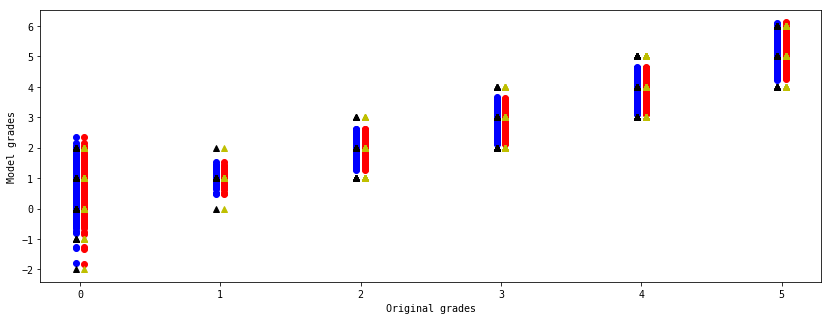

Model trained with 1st normalization has a success rate of 80.25%
Model trained with 2nd normalization has a success rate of 80.10000000000001%


In [14]:
plt.plot(y_test-0.03, pred1, 'bo')
plt.plot(y_test+0.03, pred2, 'ro')
plt.plot(y_test-0.03, np.round(pred1), 'k^')
plt.plot(y_test+0.03, np.round(pred2), 'y^')
plt.xlabel("Original grades")
plt.ylabel("Model grades")
plt.show()

print("Model trained with 1st normalization has a success rate of {}%".format(
    100*(np.sum(np.round(pred1[:,0]) == y_test) / len(y_test))))
print("Model trained with 2nd normalization has a success rate of {}%".format(
    100*(np.sum(np.round(pred2[:,0]) == y_test) / len(y_test))))

The success rates can be considered identical and it gives sense as both normalizations are equivalent and the model is linear. However, there is a big variance and the values go out of range.

### Conclusion

Even though, about 80% success rate in the model is much better than being given marks at random (with 20% probability for each grade), I still would not like this model to be responsible for grading me.

As said in the beginning, there are many options how the relations can be and it seems that it indeed is not a linear one.

I have been thinking to altern the activation function, some had pretty nice results such as 'elu' but I ultimately wanded to make a discrete one and then I realized the gradient method could not work in that case...